# Hate Speech Identifier

## Import

In [76]:
# nltk library
import nltk
nltk.download("stopwords")
nltk.download("punkt")

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag

from collections import defaultdict

import pandas as pd
import numpy as np
import re   # Regular expressions
import requests
from io import StringIO
import string

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import( 
    roc_auc_score, 
    roc_curve,
    auc, 
    confusion_matrix,
    recall_score, 
    precision_score, 
    accuracy_score,
    classification_report,
    plot_confusion_matrix
)
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.preprocessing import minmax_scale, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel

# Misc
import matplotlib.pyplot as plt
import textstat
from scipy.sparse import hstack
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
from joblib import dump, load

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuabaron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joshuabaron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read Data

In [25]:
LINKS = {
    "df_9": 'https://drive.google.com/file/d/1PgYUKf5awbdVF_9iHvz8AynBEfTNrWXK/view?usp=sharing',
    "df_20": 'https://drive.google.com/file/d/1DNvxeXPbknDCjShonzJwgLVIvgC1A8Ae/view?usp=sharing'
}
def read_from_google_sheet(url: str) -> pd.DataFrame:
    file_id = url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
    url = requests.get(dwn_url).text
    csv_raw = StringIO(url)
    return pd.read_csv(csv_raw)

def read_data():
    df = read_from_google_sheet(LINKS['df_9'])
    
    return df

In [26]:
df = read_data()
print(df.shape)
df.head()

(24783, 7)


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Re-format Data
- Offensive tweets = all tweets labeled as 0 or 1 -> Re-label as 0
- Non-offensive = all tweets labeled as 2 -> Re-label as 1

In [27]:
df = df[['tweet', 'class']]
df['class'] = df['class'].apply(lambda x: 1 if x == 2 else 0)
print('Number of offensive samples:', df[df['class'] == 0].shape[0])
print('Number of non-offensive samples:', df[df['class'] == 1].shape[0])

Number of offensive samples: 20620
Number of non-offensive samples: 4163


In [28]:
# tweet parsing
def preprocess(tweet: str):
    space_pattern = '\s+'
    url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[^\s]+'
    symbol_regex = '&#[^\s]+'
    
    parsed_tweet = tweet.lower()
    parsed_tweet = re.sub(space_pattern, ' ', parsed_tweet)
    parsed_tweet = re.sub(url_regex, 'URLHERE', parsed_tweet)
    parsed_tweet = re.sub(symbol_regex, ' ', parsed_tweet)
    parsed_tweet = re.sub(mention_regex, 'MENTIONHERE', parsed_tweet)
    
    return parsed_tweet

### Extract Features

In [29]:
def analyzer(doc: str):
    stemmer = PorterStemmer()
    words = word_tokenize(doc)
    filtered_words = [word for word in words if not word in all_stopwords and word.isalnum()]
    
    return [stemmer.stem(word) for word in filtered_words if word not in ['URLHERE', 'MENTIONHERE']]

In [43]:
all_stopwords = stopwords.words('english')
all_stopwords += ['user', '@', '!', 'rt', 'http', 'lol', 'like', 'amp', 'co', 'get', 'ff']
vectorizer = TfidfVectorizer(
    preprocessor=preprocess,
    stop_words=all_stopwords,
    min_df=5,
    max_df=.75,
    analyzer=analyzer,
    ngram_range=(2,4),
    smooth_idf=False,
    max_features=10000
)
# X_tweet = vectorizer.fit_transform(df.tweet)

In [44]:
def tokenize(tweet):
    stemmer = PorterStemmer()
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

char_vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    stop_words=all_stopwords,
    min_df=5,
    max_df=.5,
    ngram_range=(3,5),
    smooth_idf=False,
    max_features=10000
)

In [106]:
def getSentiment(df):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    scores = defaultdict(list)
    for i in range(len(df)):
        score_dict = sentiment_analyzer.polarity_scores(df[i])
        scores['neg'].append(score_dict['neg'])
        scores['neu'].append(score_dict['neu'])
        scores['pos'].append(score_dict['pos'])
        scores['compound'].append(score_dict['compound'])
    return np.array(pd.DataFrame(scores))

In [107]:
feature_union = FeatureUnion([
    ('word_vec', vectorizer),
    ('char_vec', char_vectorizer),
    ('sentiment', FunctionTransformer(getSentiment))
])

In [111]:
X, y = vectorizer.fit_transform(df['tweet']), df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.3)

### SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print(X_train_sm.shape, y_train_sm.shape)

### SMOTE

clf = LinearSVC(max_iter=1000000, class_weight={1: 4.5, 0: 1}, loss='hinge')
clf.fit(X_train_sm, y_train_sm)

pipeline = Pipeline([
    ('feature_union', feature_union),
    ('select_from_model', SelectFromModel(LogisticRegression(max_iter=100000))),
    ('classifier', clf)
])

pipeline.fit(df['tweet'], y)

dump(pipeline, 'model.joblib')

(28868, 4250) (28868,)


Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('word_vec',
                                                 TfidfVectorizer(analyzer=<function analyzer at 0x1a23354b90>,
                                                                 max_df=0.75,
                                                                 max_features=10000,
                                                                 min_df=5,
                                                                 ngram_range=(2,
                                                                              4),
                                                                 preprocessor=<function preprocess at 0x1a24a17950>,
                                                                 smooth_idf=False,
                                                                 stop_words=['i',
                                                                             'me',
                            

In [35]:
report = classification_report(y_test, clf.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      6186
           1       0.75      0.94      0.83      1249

    accuracy                           0.94      7435
   macro avg       0.87      0.94      0.90      7435
weighted avg       0.95      0.94      0.94      7435



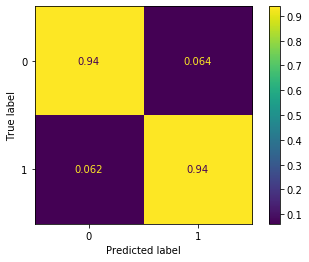

In [36]:
cm = plot_confusion_matrix(clf, X_test, y_test, normalize='true')

In [112]:
def class_to_name(class_label):
    """
    This function is used to map a numeric
    feature name to a particular class.
    """
    if class_label == 0:
        return "Offensive speech"
    elif class_label == 1:
        return "Not offensive speech"
    else:
        return "No label"

class_to_name(pipeline.predict(['Being gay is not a crime'])[0])

'Offensive speech'